# Data Analysis for AirBnB data from Seattle

### Import relevant packages and import the data sets

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11, 4)})
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
df = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')

Set pandas option to show all columns and not to truncate the columns

In [16]:
pd.set_option('display.max_columns', None)

### Investigate general characteristics of all data sets

In [17]:
df.shape

(1393570, 4)

In [18]:
listing.shape

(3818, 92)

In [19]:
df.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [20]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

## Analysis of Data set 1: Calendar of listings

### Handling missing data and pre-processing

Convert date column to a time stamp

In [21]:
df.date = pd.to_datetime(df.date)
df.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
dtype: object

Create columns for day of the week and month of the year

In [22]:
df_dates = df.copy()
df_dates['DayOfWeek'] = df_dates['date'].apply(lambda x: x.day_name())
df_dates['Month'] = df_dates['date'].apply(lambda x: x.month)
df_dates['available'] = df_dates['available'].apply(lambda x: x=='t')
df_dates.head(3)

,listing_id,date,available,price,DayOfWeek,Month
0,241032,2016-01-04,True,$85.00,Monday,1
1,241032,2016-01-05,True,$85.00,Tuesday,1
2,241032,2016-01-06,False,NaN,Wednesday,1


View columns with no missing values

In [23]:
no_nulls = set(df_dates[df_dates.columns[~df_dates.isnull().any()]].columns)
no_nulls = set(df_dates.columns[df_dates.isnull().mean()==0])
no_nulls

{'DayOfWeek', 'Month', 'available', 'date', 'listing_id'}

View columns with more that 5% missing values

In [24]:
most_missing_cols = df.columns[df.isnull().mean()>0.05]
print (most_missing_cols)

Index(['price'], dtype='object')


View the number of missing values in the price column

In [25]:
missing = df.price.isnull().value_counts()
missing

False    934542
True     459028
Name: price, dtype: int64

Check for the number of available listings for the entire data set.

True     934542
False    459028
Name: available, dtype: int64


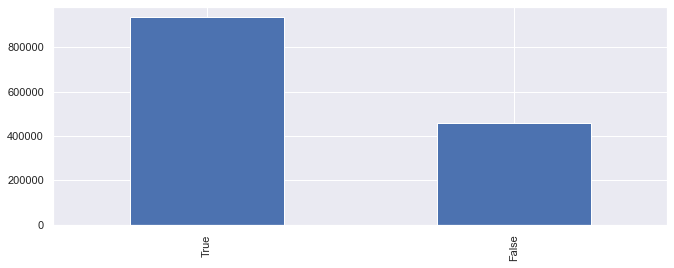

In [26]:
values = df_dates.available.value_counts()
values.plot(kind='bar')
print(values)

The number of missing values of price column correspond to the number of available listings exactly. We can assume a nan value is assigned to a listing when it is not occupied. Thus it is safe to insert a price of zero into nan values for price and convert price to float for calculations.

In [27]:
df_dates_price = df_dates.copy() 
df_dates_price.at[df_dates_price['price'].isnull(), 'price'] = 0
df_dates_price['price'] = df_dates_price['price'].str.replace("[$, ]","").astype('float')
df_dates_price.at[df_dates_price['price'].isnull(), 'price'] = 0
df_dates_price.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
DayOfWeek             object
Month                  int64
dtype: object

### Answering of business questions

What listing has generated the larget amount of revenue over the data period?

<AxesSubplot:xlabel='id'>

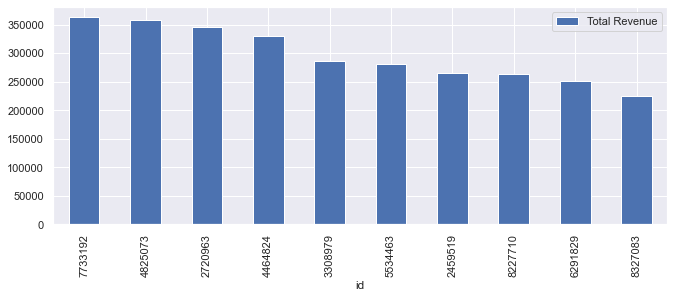

In [28]:
revenue_per_listing = df_dates_price.groupby('listing_id').sum()[['price']]
revenue_per_listing['id'] = revenue_per_listing.index
revenue_per_listing.reset_index(drop=True, inplace=True)
revenue_per_listing=revenue_per_listing.rename(columns = {'price':'Total Revenue', 'id':'id'})
revenue_per_listing_sorted = revenue_per_listing.groupby('id').sum().sort_values(by='Total Revenue', ascending=False).head(10)
revenue_per_listing_sorted.plot.bar()

How many available listings were there on each of the day of the week for the year?

In [29]:
df_dates.groupby('DayOfWeek').count()[['available']]

,available
DayOfWeek,
Friday,198536
Monday,202354
Saturday,198536
Sunday,198536
Thursday,198536
Tuesday,198536
Wednesday,198536


How many available listings exist for each month of the year?

In [30]:
df_dates.groupby('Month').count()[['available']]

,available
Month,
1,114540
2,110722
3,118358
4,114540
5,118358
6,114540
7,118358
8,118358
9,114540


How does the available listing trend look for the entire year?

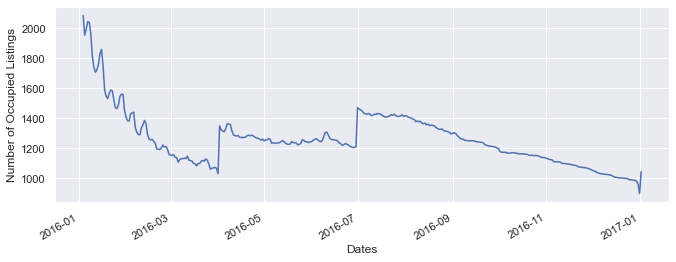

In [107]:
occupied_listings = df_dates[df_dates['available']==False]
occupied_listings.date.value_counts().plot()
plt.xlabel('Dates')
plt.ylabel('Number of Occupied Listings')
plt.savefig('occupancy_full_range.png');

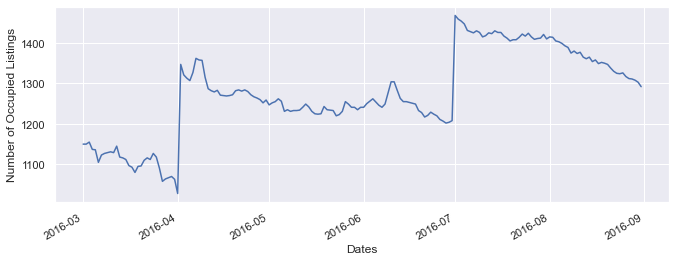

In [109]:
occupied_listings_slice = occupied_listings.set_index('date')
occupied_listings_slice.loc['2016-03':'2016-08'].index.value_counts().plot()
plt.xlabel('Dates')
plt.ylabel('Number of Occupied Listings')
plt.savefig('occupancy_focused_range.png');

How many unique listings are there in the dataset?

In [32]:
unique_listings = df.listing_id.value_counts()
len(unique_listings)

3818

## Data set 2: Listings

### Handling missing data and preprocessing

In [33]:
listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [34]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [35]:
listing.shape

(3818, 92)

Create a total revenue column in the listing database indicating the total revenue of each listing as calculated using the df_dates data set. This is achieved by merging the two data sets on the listing id column

In [36]:
listing_revenue = pd.merge(listing, revenue_per_listing, on='id')
listing_revenue.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Total Revenue
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,29410.0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,49741.0


#### Business questions answered

What is the area in Seattle that generated the most revenue over the year?

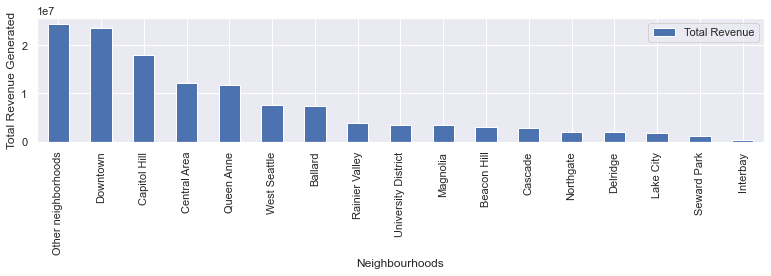

In [111]:
listing_revenue.groupby('neighbourhood_group_cleansed').sum()[['Total Revenue']].sort_values(by='Total Revenue',ascending=False).plot.bar()
plt.ylabel('Total Revenue Generated')
plt.xlabel('Neighbourhoods')
plt.tight_layout()
plt.savefig('total_revenue_neighbourhoods.png')

Considering the highest revenue is coming from other neighbourhoods, is this because there are more listings or is this because it is more expensive listings? Lets see what the average listing price is per area?

In [38]:
cal = df_dates_price.copy()
cal.head(2)

,listing_id,date,available,price,DayOfWeek,Month
0,241032,2016-01-04,True,85.0,Monday,1
1,241032,2016-01-05,True,85.0,Tuesday,1


In [39]:
cal=cal.rename(columns={"listing_id": "id"})
cal.head(2)

,id,date,available,price,DayOfWeek,Month
0,241032,2016-01-04,True,85.0,Monday,1
1,241032,2016-01-05,True,85.0,Tuesday,1


In [40]:
listing_cal = pd.merge(cal, listing_revenue, on='id')

In [41]:
listing_cal.head(2)

,id,date,available,price_x,DayOfWeek,Month,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price_y,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Total Revenue
0,241032,2016-01-04,True,85.0,Monday,1,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,29410.0
1,241032,2016-01-05,True,85.0,Tuesday,1,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,29410.0


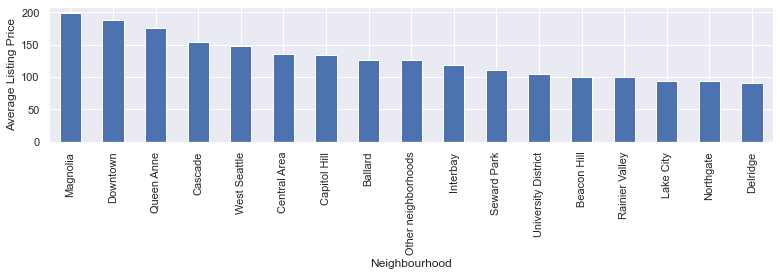

In [124]:
occupied_df = listing_cal[listing_cal['available']==True]
occupied_df.groupby('neighbourhood_group_cleansed').mean()['price_x'].sort_values(ascending=False).plot.bar()
plt.xlabel('Neighbourhood')
plt.ylabel('Average Listing Price')
plt.tight_layout()
plt.savefig('average_price_listings.png');

Which neighbourhoods have the highest occupancy rate?

In [43]:
not_occupied_df = listing_cal[listing_cal['available']==False]

In [44]:
occupancy_rate_area = not_occupied_df.groupby('neighbourhood_group_cleansed').count()['id']/listing_cal.groupby('neighbourhood_group_cleansed').count()['id']

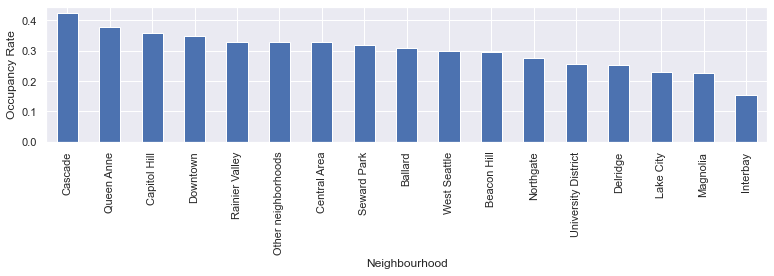

In [115]:
occupancy_rate_area.sort_values(ascending=False).plot.bar()
plt.xlabel('Neighbourhood')
plt.ylabel('Occupancy Rate')
plt.tight_layout()
plt.savefig('occupancy_rate_neighbourhoods.png')

What effect does being a super host have on the occupancy rate of the listing?

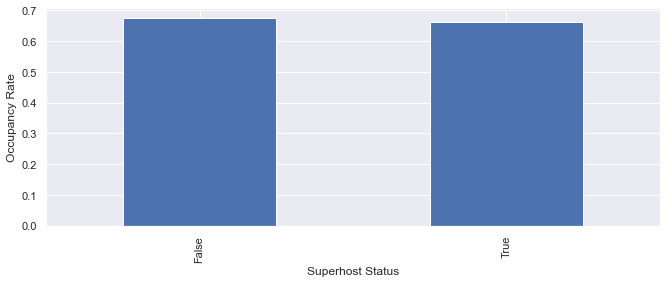

In [131]:
occupancy_rate_superhost = occupied_df.groupby('host_is_superhost').count()['id']/listing_cal.groupby('host_is_superhost').count()['id']
occupancy_rate_superhost.rename({'t':True, 'f':False}, inplace=True)
occupancy_rate_superhost.sort_values(ascending=False).plot.bar()
plt.xlabel('Superhost Status')
plt.ylabel('Occupancy Rate')
plt.savefig('occupancy_rate_superhosts.png')

In [47]:
listing_cal.head(2)

,id,date,available,price_x,DayOfWeek,Month,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price_y,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Total Revenue
0,241032,2016-01-04,True,85.0,Monday,1,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,29410.0
1,241032,2016-01-05,True,85.0,Tuesday,1,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,29410.0


## What is the affect of amenities and other listing characteristics on the listing price?

### Development of a machine learning model to predict the listing price provided a certain set of listing characteristics and ammenities

### Preprocessing of data

In [48]:
listing.at[df_dates_price['price'].isnull(), 'price'] = 0
listing['price'] = listing['price'].str.replace("[$, ]","").astype('float')
listing.at[listing['price'].isnull(), 'price'] = 0

In [49]:
listing['price'].dtypes

dtype('float64')

In [50]:
listing_processed = listing[['price', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']]

In [51]:
listing_processed.head(2)

,price,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
0,85.0,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN
1,150.0,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN


In [52]:
listing_processed.dtypes

price                           float64
neighbourhood_group_cleansed     object
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
amenities                        object
square_feet                     float64
dtype: object

A function that is used to extract individual ammenties from the ammenities strings

In [53]:
def process_ammenities(ammenities_str):
    '''
    INPUT
    ammenities_str - string containing amenities
    
    OUTPUT
    ammenities_str - A list of amenities
    
    This function does the following:
    1. Remove unwanted characters from the amenities string
    2. Splits the string at the location of a commma
    3. Creates a list of amenities and returns it
    '''
    char_to_remove = '{}\"'
    for char in char_to_remove:
        ammenities_str = ammenities_str.replace(char,"")
    ammenities_str = ammenities_str.split(',')
    return ammenities_str

In [54]:
def columnize_ammenities(ammenities_col):
    '''
    INPUT
    ammenities_col - pandas series containing all amenities
    
    OUTPUT
    dummy_df - pandas data frame with dummy variables created for all amenities
    
    This function does the following:
    1. Determines all unique amenities
    2. Creates an empty dataframe
    3. Populates the empty dataframe with dummy variables for each of the amenities
    2. Returns a data frame with dummy variables of each of teh amenities
    '''
    
    unique_list = []
    dummy_df = pd.DataFrame()
    for index in range (ammenities_col.shape[0]):
        for category in ammenities_col[index]:
            if (category not in unique_list):
                unique_list.append(category)
                dummy_df[category] = None
                dummy_df.loc[index,category] = 1
            elif (category in unique_list):
                dummy_df.loc[index,category] = 1
    dummy_df = dummy_df.fillna(0)
    return dummy_df

In [55]:
listing_processed['amenities'] = listing_processed['amenities'].apply(process_ammenities)

<ipython-input-55-e2b90f99d8f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listing_processed['amenities'] = listing_processed['amenities'].apply(process_ammenities)


In [56]:
dummy_df = columnize_ammenities(listing_processed['amenities'])

In [57]:
dummy_df.drop('', axis=1, inplace=True)

In [58]:
dummy_df.columns

Index(['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning',
       'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer',
       'Free Parking on Premises', 'Buzzer/Wireless Intercom',
       'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit',
       'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed',
       'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub',
       'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in',
       'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace',
       'Suitable for Events', 'Elevator in Building', 'Lock on Bedroom Door',
       'Wheelchair Accessible', 'Gym', 'Pool', 'Smoking Allowed',
       'Other pet(s)', 'Doorman', 'Washer / Dryer'],
      dtype='object')

Combine the dummy_df dataframe containing amenities with the listing processed dataframe and drop the orignal amenities column

In [59]:
listing_dummy = pd.concat([listing_processed,dummy_df], axis=1)
listing_dummy.drop('amenities', axis=1, inplace=True)

In [60]:
listing_dummy.head(2)

,price,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,Free Parking on Premises,Buzzer/Wireless Intercom,Smoke Detector,Carbon Monoxide Detector,First Aid Kit,Safety Card,Fire Extinguisher,Essentials,Pets Allowed,Pets live on this property,Dog(s),Cat(s),Hot Tub,Indoor Fireplace,Shampoo,Breakfast,24-Hour Check-in,Hangers,Hair Dryer,Iron,Laptop Friendly Workspace,Suitable for Events,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,85.0,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,NaN,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,150.0,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,NaN,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Function for creating dummy variables for all other categorical variables

In [61]:
def add_dummies_to_dataframe(columns, dataframe):
    '''
    INPUT
    columns - a list of columns to create dummy variables for
    dataframe - dataframe to add dummy variables to after dummy variables have been created
    
    OUTPUT
    dataframe - pandas data frame with dummy variables created for all amenities
    
    This function does the following:
    1. Creates dummy variables for each of the columns identified in columns list
    2. Removes the column from the data frame once a dummy variable has been created for it
    3. Returns a dataframe with identified columns dropped and dummy variables created for them
    '''
    for col in columns:
        dataframe = pd.concat([dataframe,pd.get_dummies(dataframe[col])], axis=1)
        dataframe.drop(col, axis=1, inplace=True)
    return dataframe

Call function for creating dummies for other categorical variables

In [62]:
columns_to_dummy = ['neighbourhood_group_cleansed','property_type','room_type', 'bed_type']
dummied_listing_df = add_dummies_to_dataframe(columns_to_dummy, listing_dummy)
dummied_listing_df.head(2)

,price,accommodates,bathrooms,bedrooms,beds,square_feet,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,Free Parking on Premises,Buzzer/Wireless Intercom,Smoke Detector,Carbon Monoxide Detector,First Aid Kit,Safety Card,Fire Extinguisher,Essentials,Pets Allowed,Pets live on this property,Dog(s),Cat(s),Hot Tub,Indoor Fireplace,Shampoo,Breakfast,24-Hour Check-in,Hangers,Hair Dryer,Iron,Laptop Friendly Workspace,Suitable for Events,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,85.0,4,1.0,1.0,1.0,NaN,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,150.0,4,1.0,1.0,1.0,NaN,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Handle last remaining missing values in the square feet column

In [63]:
missing_vals = dummied_listing_df['square_feet'].isnull().sum()/dummied_listing_df['square_feet'].shape[0]
print (missing_vals)

0.9745940282870613


Since square feet column has 97% missing values, we can drop this column.

In [64]:
dummied_listing_df.drop('square_feet', inplace=True, axis=1)
dummied_listing_df.head(2)

,price,accommodates,bathrooms,bedrooms,beds,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,Free Parking on Premises,Buzzer/Wireless Intercom,Smoke Detector,Carbon Monoxide Detector,First Aid Kit,Safety Card,Fire Extinguisher,Essentials,Pets Allowed,Pets live on this property,Dog(s),Cat(s),Hot Tub,Indoor Fireplace,Shampoo,Breakfast,24-Hour Check-in,Hangers,Hair Dryer,Iron,Laptop Friendly Workspace,Suitable for Events,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,85.0,4,1.0,1.0,1.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,150.0,4,1.0,1.0,1.0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [65]:
dummied_listing_df.describe()

,price,accommodates,bathrooms,bedrooms,beds,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,Free Parking on Premises,Buzzer/Wireless Intercom,Smoke Detector,Carbon Monoxide Detector,First Aid Kit,Safety Card,Fire Extinguisher,Essentials,Pets Allowed,Pets live on this property,Dog(s),Cat(s),Hot Tub,Indoor Fireplace,Shampoo,Breakfast,24-Hour Check-in,Hangers,Hair Dryer,Iron,Laptop Friendly Workspace,Suitable for Events,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
count,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.00000,3818.000000
mean,127.976166,3.349398,1.259469,1.307712,1.735394,0.674175,0.378732,0.736249,0.960450,0.177318,0.896543,0.949974,0.514144,0.783656,0.784966,0.567575,0.140911,0.859350,0.650864,0.440021,0.190414,0.575170,0.847826,0.123625,0.231273,0.133316,0.100052,0.079361,0.232059,0.699319,0.076218,0.161341,0.221582,0.202724,0.194343,0.195128,0.054741,0.205605,0.026192,0.078575,0.115767,0.041645,0.021477,0.013358,0.022263,0.000524,0.060241,0.030906,0.148507,0.023311,0.096647,0.020691,0.138816,0.002881,0.017548,0.015977,0.020953,0.207962,0.077266,0.041645,0.011524,0.031954,0.053169,0.447355,0.009691,0.002095,0.003405,0.005500,0.003405,0.000524,0.023834,0.000524,0.453903,0.010477,0.005762,0.001310,0.030906,0.000786,0.000262,0.665532,0.303824,0.030644,0.007072,0.003405,0.019382,0.01231,0.957831
std,90.250022,1.977599,0.590369,0.883395,1.139480,0.468744,0.485135,0.440723,0.194924,0.381988,0.304595,0.218028,0.499865,0.411805,0.410900,0.495478,0.347976,0.347705,0.476759,0.496454,0.392679,0.494382,0.359236,0.329196,0.421702,0.339960,0.300109,0.270337,0.422202,0.458614,0.265381,0.367893,0.415366,0.402081,0.395746,0.396351,0.227503,0.404196,0.159726,0.269110,0.319988,0.199802,0.144988,0.114816,0.147557,0.022884,0.237964,0.173086,0.355648,0.150908,0.295516,0.142368,0.345800,0.053605,0.131320,0.125403,0.143247,0.405903,0.267047,0.199802,0.106745,0.175900,0.224400,0.497286,0.097977,0.045733,0.058260,0.073969,0.058260,0.022884,0.152553,0.022884,0.497936,0.101831,0.075700,0.036169,0.173086,0.028024,0.016184,0.471866,0.459968,0.172375,0.083807,0.058260,0.137881,0.11028,0.201000
min,20.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Bathrooms, bedrooms and beds columns still have missing values as seen in the count of values above. There are not that many missing values, so it is safe to fill them with the mean of the column.

In [136]:
dummied_listing_df['bathrooms'].fillna(dummied_listing_df['bathrooms'].mean(), inplace=True)
dummied_listing_df['bedrooms'].fillna(dummied_listing_df['bedrooms'].mean(), inplace=True)
dummied_listing_df['beds'].fillna(dummied_listing_df['beds'].mean(), inplace=True)
dummied_listing_df.describe()
dummied_listing_df.to_csv('dummied_listing_df.csv', index=False)

The preprocessing has been completed and data can now be used for machine learning. Save price in Y and save all other predictive variables in X

### Creation of the machine learning model

In [67]:
X = dummied_listing_df.drop('price', axis=1)
Y = dummied_listing_df['price']

Do the train test split using sklearn with a train/test size of 70/30

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [69]:
#instantiate
#fit training
#predict test data
#score your model on the test

linear_model = LinearRegression(normalize=True)
linear_model.fit(X_train, Y_train)

LinearRegression(normalize=True)

In [137]:
def create_coeff_df(coeffs, X_train):
    '''
    INPUT
    coeffs - list of coefficients
    X_train - X training set
    OUTPUT
    co_df - dataframe containing the model coefficient for each variable 
    
    This function does the following:
    1. Creates a dataframe with features as rows
    2. Creates columns to show model coefficient for features
    3. Returns the dataframe indicating the coefficient for each feature of the model
    '''
    co_df = pd.DataFrame()
    co_df['Features'] = X_train.columns
    co_df['Coefficients'] = coeffs
    co_df['AbsCoefficients'] = np.abs(coeffs)
    co_df = co_df.sort_values('AbsCoefficients', ascending=False)
    return co_df

co_df = create_coeff_df(linear_model.coef_, X_train)
co_df.to_csv('coefficients.csv', index=False)
co_df.head(15)

,Features,Coefficients,AbsCoefficients
81,Airbed,7.610310e+13,7.610310e+13
82,Couch,7.610310e+13,7.610310e+13
85,Real Bed,7.610310e+13,7.610310e+13
84,Pull-out Sofa,7.610310e+13,7.610310e+13
83,Futon,7.610310e+13,7.610310e+13
78,Entire home/apt,5.981072e+13,5.981072e+13
79,Private room,5.981072e+13,5.981072e+13
80,Shared room,5.981072e+13,5.981072e+13
55,Northgate,-1.591061e+13,1.591061e+13
58,Rainier Valley,-1.591061e+13,1.591061e+13


Calculate the r2 score for the test set and the training set

In [71]:
y_test_predictions = linear_model.predict(X_test)
y_train_predictions = linear_model.predict(X_train)

test_score = r2_score(Y_test, y_test_predictions)
train_score = r2_score(Y_train, y_train_predictions)
print ('The test score is ',test_score,', and the training score is ', train_score)

The test score is  0.5923490248901038 , and the training score is  0.5797682125262744


Plot the prediction error of each prediction

count    1146.000000
mean       37.724272
std        45.493125
min         0.125000
25%        12.226562
50%        25.015625
75%        47.445312
max       435.187500
Name: price, dtype: float64


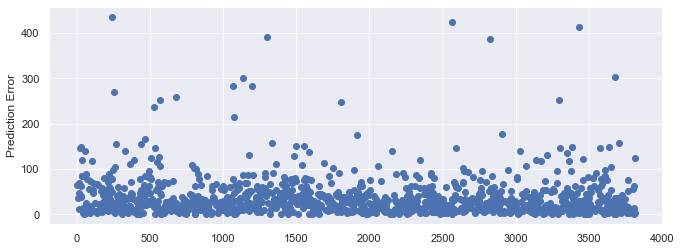

In [132]:
prediction_error = abs(Y_test - y_test_predictions)
error_plt = plt.plot(prediction_error, marker='o', linestyle='')
plt.ylabel('Prediction Error')
plt.savefig('prediction_error.png')
print (prediction_error.describe())